In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import copy
import json
from PIL import Image

#### 数据读取与预处理

In [2]:
data_dir = "/data2/cuimengjun/01DataSet/flower_data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

#### 制作好数据源
- data_transforms中指定了所有图像预处理操作(实际中可能仅需要使用部分)
- ImageFolder假设所有的文件按文件夹保存好, 每个文件夹下面存储同一类别图片, 文件夹的名字为类别名字

In [5]:
data_transforms = {
    "train":
        transforms.Compose([
            transforms.Resize([96, 96]),
            transforms.RandomRotation(45), # -45~45之间随机旋转
            transforms.CenterCrop(64), # 从重心开始裁剪
            transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
            transforms.RandomVerticalFlip(p=0.5), # 随机垂直翻转
            transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 亮度/对比度/饱和度/色相
            transforms.RandomGrayscale(p=0.025), # 一定概率转成灰度率
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #均值, 标准差
        ]),
    "valid":
        transforms.Compose([
            transforms.Resize([64, 64]),
            transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}

In [10]:
batch_size = 128

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "valid"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ["train", "valid"]}
datasets_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes

In [8]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: /data2/cuimengjun/01DataSet/flower_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=[96, 96], interpolation=bilinear)
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(64, 64))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: /data2/cuimengjun/01DataSet/flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear)
                ToTensor()
   

In [9]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f00f30e92e0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f00f30c4c40>}

In [11]:
datasets_sizes

{'train': 6552, 'valid': 818}

#### 读取标签对应的实际名字

In [12]:
with open("./cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

In [13]:
cat_to_name['1']

'pink primrose'

#### 加载models中提供的模型, 并且直接用训练好的权重当作初始化参数

In [14]:
model_name = "resnet"
feature_extract = True

In [15]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available.  Training on GPU ...")
    
device = torch.device("cuda:0" if train_on_gpu else "cpu")

CUDA is available.  Training on GPU ...


#### 模型参数是否更新

In [16]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
model_ft = models.resnet18()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 将模型输出层改为适配自己任务

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_in = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_in, num_classes) # 类别数根据具体任务, 这个函数写的不好
    input_size = 64 # 输入大小根据具体任务 暂时写死
    
    return model_ft, input_size

#### 设置哪些层需要训练

In [34]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)
# GPU or CPU
model_ft = model_ft.to(device)
# 模型存储
filename = "best.pt"
# 是否训练所有层
params_to_update = model_ft.parameters()
print("Prams to learn: ")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)

Prams to learn: 
	 fc.weight
	 fc.bias


In [22]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 优化器设置

In [27]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.8) # lr每10步衰减为原来的80%
criterion = nn.CrossEntropyLoss()

#### 训练部分

In [28]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=30, filename="best.pt"):
    # 记录时间
    since = time.time()
    # 记录最好的结果
    best_acc = 0
    # 模型放在哪里
    model.to(device)
    # 训练中打印数据
    val_acc_history = []
    train_acc_history = []
    valid_losses = []
    train_losses = []
    # lr
    lrs = [optimizer.param_groups[0]['lr']]
    
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 训练和验证
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                # 训练阶段更新参数
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
                # 计算损失
                running_loss += loss.item()  * inputs.size(0) # batch
                running_corrects += torch.sum(preds == labels)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                
            time_elapsed = time.time()
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 得到best模型
            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                state = {
                    "state_dict": model.state_dict(), # 字典 key各层名字 value训练好的权重
                    "best_acc": best_acc,
                    "optimizer": optimizer.state_dict(),
                }
                torch.save(state, filename)
                
            if phase == "valid":
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
            if phase == "train":
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
            
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        lrs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 训练完后用最好的一次当做模型最终的结果, 等着一会测试
    model.load_state_dict(best_model)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, lrs 

#### 训练

In [29]:
# 先只训练输出层
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
Time elapsed 27834625m 59s
train Loss: 3.4606 Acc: 0.3053
Time elapsed 27834626m 4s
valid Loss: 3.4541 Acc: 0.2958
Optimizer learning rate : 0.0100000

Epoch 1/19
----------
Time elapsed 27834626m 50s
train Loss: 2.8606 Acc: 0.3973
Time elapsed 27834626m 55s
valid Loss: 3.4585 Acc: 0.3068
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 27834627m 42s
train Loss: 2.7260 Acc: 0.4303
Time elapsed 27834627m 46s
valid Loss: 3.8493 Acc: 0.2922
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 27834628m 33s
train Loss: 2.9042 Acc: 0.4225
Time elapsed 27834628m 38s
valid Loss: 3.9465 Acc: 0.2873
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 27834629m 24s
train Loss: 2.8083 Acc: 0.4449
Time elapsed 27834629m 29s
valid Loss: 3.9938 Acc: 0.2848
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 27834630m 15s
train Loss: 2.8393 Acc: 0.4463
Time elapsed 27834630m 20s
valid Loss: 4.0922 

In [32]:
# 再训练所有层
for param in model_ft.parameters():
    param.requires_grad = True
    
# 再继续训练所有参数 学习率可以小一些
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.CrossEntropyLoss()

In [35]:
# 加载之前训练好的权重参数
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [36]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=20)


Epoch 0/19
----------
Time elapsed 27834647m 22s
train Loss: 2.4075 Acc: 0.5076
Time elapsed 27834647m 27s
valid Loss: 3.9972 Acc: 0.3692
Optimizer learning rate : 0.0010000

Epoch 1/19
----------
Time elapsed 27834648m 15s
train Loss: 2.4333 Acc: 0.5114
Time elapsed 27834648m 20s
valid Loss: 4.1021 Acc: 0.3545
Optimizer learning rate : 0.0010000

Epoch 2/19
----------
Time elapsed 27834649m 7s
train Loss: 2.3861 Acc: 0.5218
Time elapsed 27834649m 12s
valid Loss: 3.9855 Acc: 0.3570
Optimizer learning rate : 0.0010000

Epoch 3/19
----------
Time elapsed 27834649m 60s
train Loss: 2.3006 Acc: 0.5276
Time elapsed 27834650m 5s
valid Loss: 4.0105 Acc: 0.3606
Optimizer learning rate : 0.0010000

Epoch 4/19
----------
Time elapsed 27834650m 52s
train Loss: 2.4187 Acc: 0.5159
Time elapsed 27834650m 57s
valid Loss: 4.0130 Acc: 0.3680
Optimizer learning rate : 0.0010000

Epoch 5/19
----------
Time elapsed 27834651m 43s
train Loss: 2.3754 Acc: 0.5201
Time elapsed 27834651m 48s
valid Loss: 4.0476 A

#### 加载训练好的模型

In [37]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='best.pt'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

#### 测试
- 测试数据处理方法需要跟训练时一直才可以 
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的, 用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化, 所以测试数据也需要先归一化
- 最后一点, PyTorch中颜色通道是第一个维度, 跟很多工具包都不一样, 需要转换

In [38]:
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [39]:
output.shape

torch.Size([128, 102])

In [40]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

#### 展示结果

In [41]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

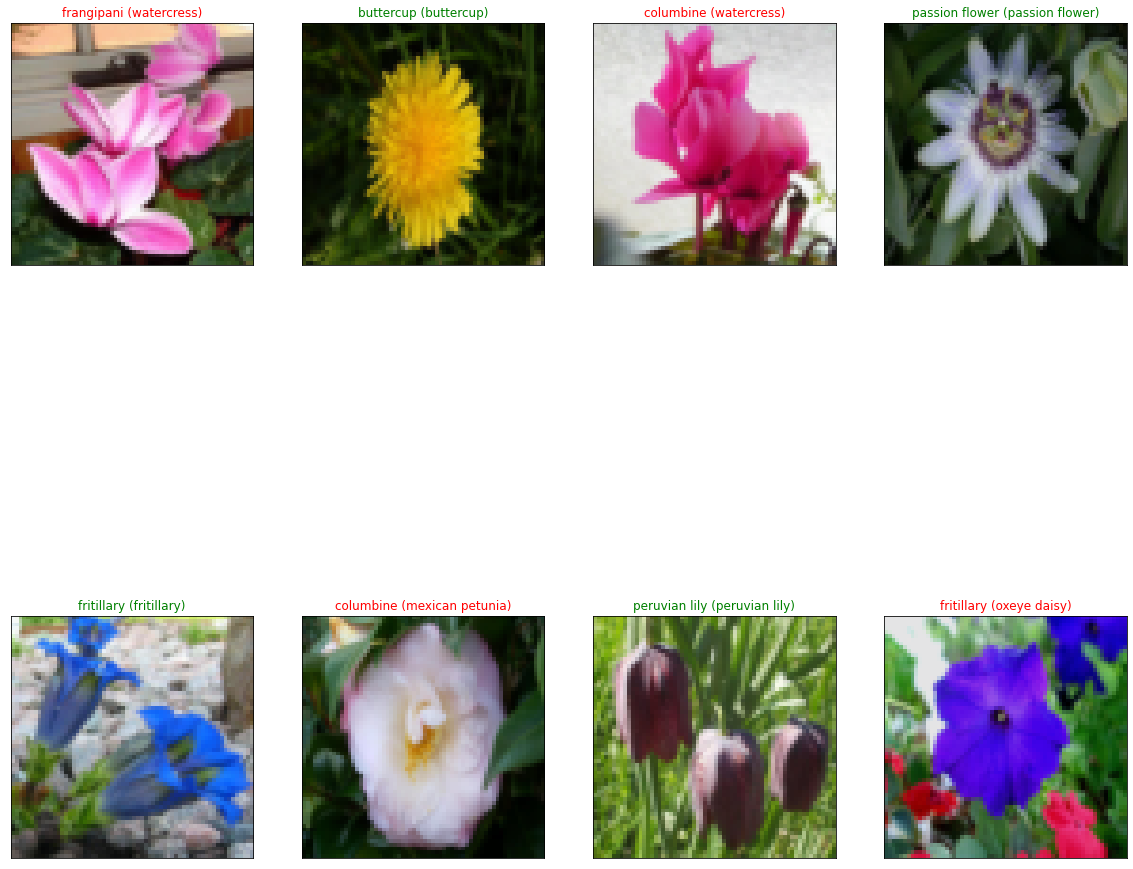

In [42]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()